## OpenCV line detection autopilot.

In a [previous post](https://wroscoe.github.io/keras-lane-following-autopilot.html#keras-lane-following-autopilot) I walked through how to create a lane keeping autopilot using an end-to-end neural network. This post shows how to create a lane keeping autopilot using line detection computer vision algorithms. 

This is essentially a python port of the [C++ computer vision autopilot](https://github.com/compound-eye/windshield/blob/master/think/Compute.cpp), written by Haoyang Wang, and Jason Devitt from [Compound Eye](http://www.compoundeye.com/). It was the only vehicle to complete the first [DIYRobocar Race](http://diyrobocars.com/?page_id=278). 

## Load Images

In [267]:
import os
import cv2
import numpy as np
import random
import math

import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

In [268]:
dir_path = '/home/wroscoe/donkey_data/sessions/wr_1240/'
images = os.listdir(dir_path)
img_paths = [os.path.join(dir_path, i) for i in images]
img_paths.sort()

#Read images, flip them vertically, and convert them to RGB color order
img_all = np.array([cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in img_paths])

#only use a couple example images
img_arr = img_all[0:5]

#find image dimensions
img = img_arr[0]
img_height = img.shape[0]
img_width = img.shape[1]


In [269]:
#helper function to show several images
def show_imgs(img_arr, cmap=None):
    
    fig, ax = plt.subplots(1, img_arr.shape[0], figsize=(15, 6),
                             subplot_kw={'adjustable': 'box-forced'})

    axoff = np.vectorize(lambda ax:ax.axis('off'))
    axoff(ax)

    for i, img in enumerate(img_arr):
        ax[i].imshow(img, cmap=cmap)

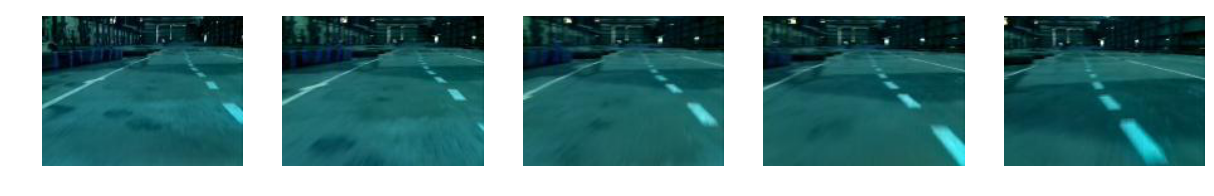

In [270]:
#show original images
show_imgs(img_arr)

## Find Lines

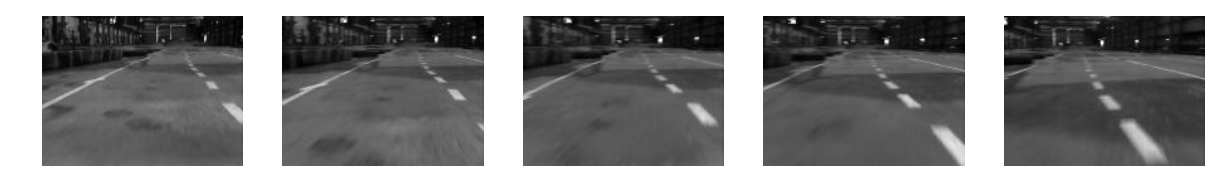

In [271]:
#remove colors and show greyscale
gray_arr = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in img_arr])
show_imgs(gray_arr, cmap='gray')

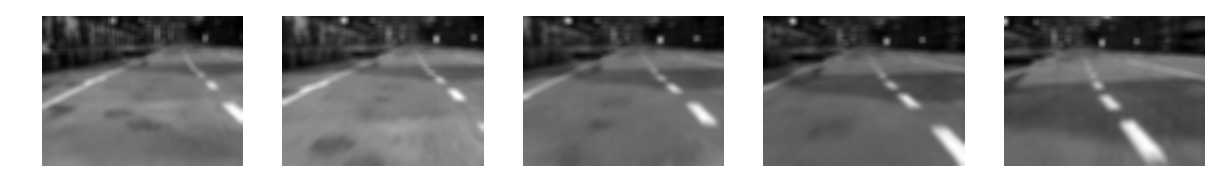

In [272]:
#blur images to avoid recognizing small lines
blur_arr = np.array([cv2.blur(arr,(5,5)) for arr in gray_arr])
#blur_arr = gray_arr
show_imgs(blur_arr, cmap='gray')

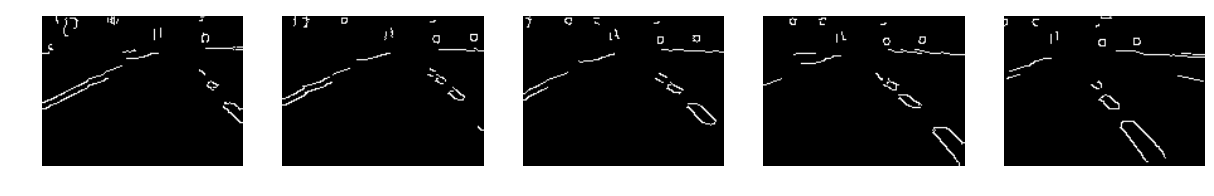

In [273]:
#use canny threshold to find edges of shapes
canny_threshold1 = 100
canny_threshold2 = 130

canny_arr = np.array([cv2.Canny(arr, canny_threshold1, canny_threshold2) for arr in blur_arr])
show_imgs(canny_arr, cmap='gray')

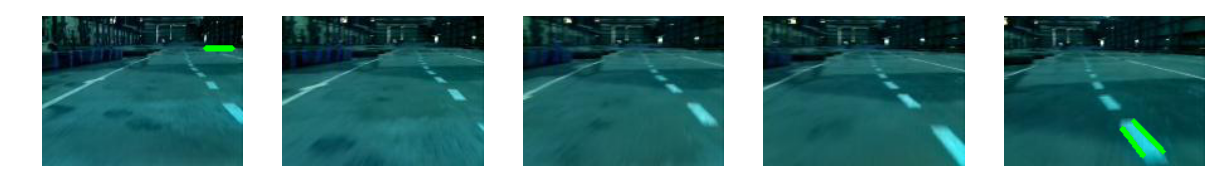

In [274]:
hough_threshold = 7
min_line_length = 80
max_gap = 20
rho = 2.
theta = .02

line_arr = []
line_coord_arr = []
line_count = 0
for i, canny in enumerate(canny_arr):
    lines = cv2.HoughLinesP(canny, rho, theta, hough_threshold, 
                            min_line_length, max_gap)
    img = img_arr[i]
    if lines is not None:
        for line in lines: 
            #format line to be drawn
            x1, y1, x2, y2 = line[0]
            line_coord = np.array([[[x1, y1], [x2, y2]]], dtype=float)

            #draw line
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),3)
            
            line_count += 1
            
    line_arr.append(img)
    
line_arr = np.array(line_arr)

show_imgs(line_arr)


## Get a birds eye view of the lines
To calculate the steering angle we'll use a perspective transform to simulate a birds eye view from the tip. This way we can calculate the actual angle of the line relative to the car. 

The first step is to calculate the required transform from the camera angle to a top view. OpenCV provides an easy function to do this if you can provide a rectangle before and after the transform. 

1. Find the corners of a rectangle on the road.
2. Define where those corners would be from a birds eye view.
3. Use OpenCV to find this transformation matrix. 
4. Use this transformation matrix to change the perspective of your images. 

I did this by first taking picture of a standard 8.5"x11" letter size paper from my car and finding the corner cordinates. 

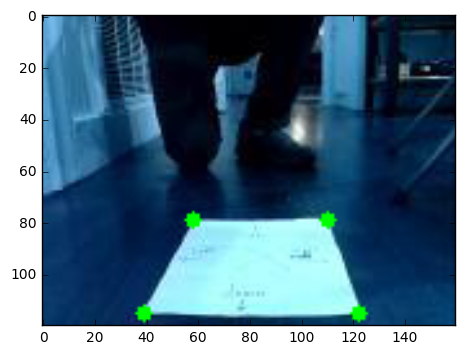

In [275]:
#Load calibration image
img_path = '/home/wroscoe/donkey_data/sessions/cv_orient/frame_00001_ttl_0_agl_0_mil_0.jpg'
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

#coordinates of corners: order is [top left, top right, bottom right, bottom left]
corners = np.array([(58,79), (110,79), (122,115), (39, 115)], dtype="float32")

#draw points on new image
img2 = img.copy()
for c in corners:
    cv2.circle(img2, tuple(c), 3, (0,255,0), -1)
    
imshow(img2)
    

Now we define where that rectangle should be if we're looking from the top veiew perspective and calculate the transformation matrix. 

In [247]:
def four_point_transform(pts):

    maxWidth, maxHeight = 300, 300
    center = (maxWidth/2, maxHeight/2)
    hwratio = 11/8.5 #letter size paper
    scale = int(maxWidth/10)
    
    center_x = 150
    center_y = 250
    
    dst = np.array([
    [center_x - scale, center_y - scale*hwratio], #top left
    [center_x + scale, center_y - scale*hwratio], #top right
    [center_x + scale, center_y + scale*hwratio], #bottom right
    [center_x - scale, center_y + scale*hwratio], #bottom left
    ], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(pts, dst)
    
    return M

M = four_point_transform(corners)
M

array([[ -3.74350087e+00,  -8.42287695e+00,   4.93206239e+02],
       [ -1.12132525e-14,  -2.25150330e+01,   1.09355353e+03],
       [ -3.33934269e-17,  -5.37261698e-02,   1.00000000e+00]])

When we apply that transformation to the same image we can see that the paper now looks like it would from the top.  

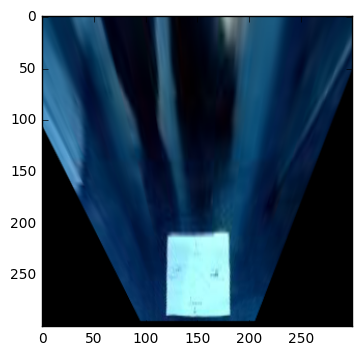

In [248]:
warped =  cv2.warpPerspective(img, M, (300, 300))
imshow(warped)

Here is the same transformation applied to pictures from the track. 

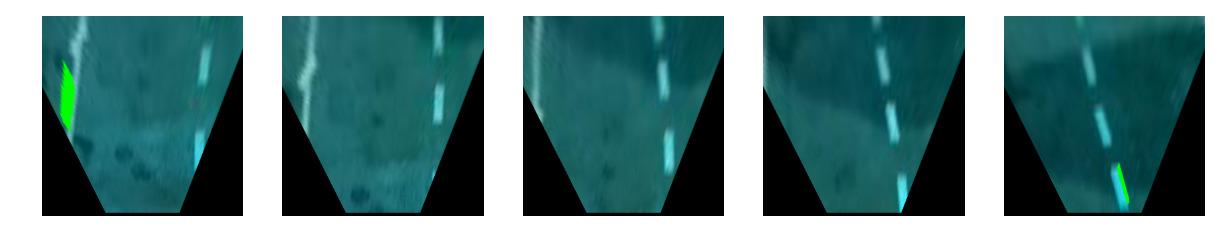

In [249]:
warped_arr = np.array([cv2.warpPerspective(i, M, (300, 300)) for i in img_arr])
show_imgs(warped_arr)
    

## Calculate steering angles

* Compute the angle that the line segments make with the horizontal.
* Filter out line segments that appear on one side of the image only and lean outwards, on the assumption that we’re not in danger of crossing those.
* Cluster the rest by angle.
* Find the cluster with the longest combined length, and set that angle as our steering angle.

### Find lines
Here we are createing a single function to extract the lines from the image and transform them to a birds eye perspective.

In [251]:
def get_lines(img, blur_pixels=5, canny_threshold1=100, canny_threshold2=130,
             rho=2, theta=.02, min_line_length=80, max_gap=20, hough_threshold=9):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.blur(img,(blur_pixels,blur_pixels))
    img = cv2.Canny(img, canny_threshold1, canny_threshold2)
    lines = cv2.HoughLinesP(img, rho, theta, hough_threshold, min_line_length, max_gap)
    
    if lines is not None:
        lines = lines.reshape((lines.shape[0],2,2))
        lines = lines.astype(float)
        lines = cv2.perspectiveTransform(lines, M)
    return lines

lines = get_lines(img_all[6])
lines

array([[[ 231.95876289, -918.3076126 ],
        [ 521.44329897, -918.3076126 ]]])

In [252]:
def line_length(arr):
    l = math.sqrt( (arr[0,0] - arr[1,0])**2 + (arr[0,1] - arr[1,1])**2 )
    return l

def line_angle(arr):
    dx = arr[1,0] - arr[0,0]
    dy = arr[1,1] - arr[0,1]
    rads = math.atan2(-dy,dx)
    rads %= 2*math.pi
    degs = -math.degrees(rads)
    if degs <= -180: 
        degs = degs + 180
        
    degs = degs + 90
    return degs

In [253]:
#calculate the angle and lenght of each line
def compute_lines(lines):
    from operator import itemgetter
    
    line_data = []
    for line in lines:
        line_data.append([line_angle(line), line_length(line)])

    sorted(line_data, key=itemgetter(0))
    return line_data

In [254]:
#cluster angles if they are within 20 degrees of each other.
def cluster_angles(line_data):
    clusters = []
    last_angle = -180
    for a, l in line_data:
        if abs(last_angle - a) > 20:
            clusters.append([(a,l)])
        else:
            clusters[-1].append((a,l))
    return clusters
            

def decide_angle(clustered_angles):
    max_length = 0
    max_cluster_id = -1
    for i, c in enumerate(clustered_angles):
        #sum lenght of lines found in clusters, filter out angles > 80 (likely in horizon)
        cluster_length = sum([l for a, l in c if abs(a) < 80])
        if cluster_length > max_length:
            max_length = cluster_length
            max_cluster_id = i

    if max_cluster_id>0:
        angles = [a for a, l in clustered_angles[max_cluster_id]]
        #return average angle of cluster
        return sum(angles)/len(angles)  
    #print(angles)
    else:
        return 0
       

## Bring it all together

In [288]:
line_count = []
decided_angles = []
for i in img_all:
    lines = get_lines(i, max_gap=9,  hough_threshold=8)    
    #print(lines)
    if lines is not None:
        line_count.append(lines.shape[0])
        line_data = compute_lines(lines)
        clustered = cluster_angles(line_data)
        angle = decide_angle(clustered)
        decided_angles.append(angle)
    else:
        decided_angles.append(0)

## Analyze Results
Now lets see how this looks compared to actual driving data. Here is the actual steering angle compared with the steering angel given by the this line detection algorthim. Its noisy but directionally accurate. 

In [289]:
def parse_img_filepath(filepath):
        f = filepath.split('/')[-1]
        f = f.split('.')[0]
        f = f.split('_')

        throttle = int(f[3])
        angle = int(f[5])
        milliseconds = int(f[7])
        
        data = {'throttle':throttle, 'angle':angle, 'milliseconds': milliseconds} 
        return data

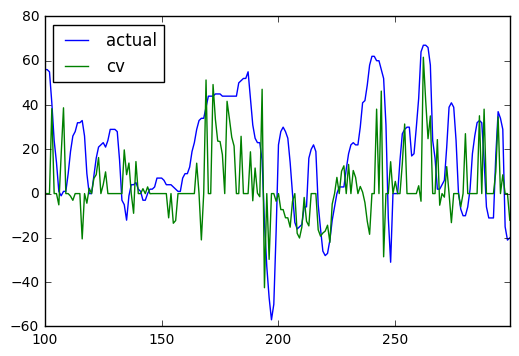

In [291]:
data = [parse_img_filepath(i) for i in img_paths]
angles = [d['angle'] for d in data]
df = pd.DataFrame({'cv':decided_angles, 'actual': angles})
df[100:300].plot()